# Data block foundations

In [1]:
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
With SwiftPM flags: []
Working in: /tmp/tmp8hq5y_nl
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 3.60s
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'FastaiNotebook_07_batchnorm' (12 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Loading library...
Installation complete!


In [ ]:
import FastaiNotebook_07_batchnorm
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
// export
import Path
import TensorFlow
import Python

In [ ]:
let plt = Python.import("matplotlib.pyplot")

## Image ItemList

### Download Imagenette

In [ ]:
//export
public let dataPath = Path.home/".fastai"/"data"

In [ ]:
//export
public func downloadImagette(path: Path = dataPath) -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
    let fname = "imagenette-160"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = shellCommand("/bin/tar", ["-xzf", (path/"\(fname).tgz").string, "-C", path.string])
    }
    return file
}

In [ ]:
let path = downloadImagette()

In [ ]:
print(path.ls())

[Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/train)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/models))]


In [ ]:
print((path/"val").ls())

[Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03888257)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03445777)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03425413)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n01440764)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03028079)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n02979186)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03394916)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n02102040)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160

Let's have a look inside a class folder (the first class is tench):

In [ ]:
let pathTench = path/"val"/"n01440764"

In [ ]:
let imgFn = Path.home/".fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"
imgFn.string

"/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"


In [ ]:
let imgBytes = Raw.readFile(filename: StringTensor(imgFn.string))
let decodedImg = Raw.decodeJpeg(contents: imgBytes, channels: 3, dctMethod: "") 

In [ ]:
decodedImg.shape

▿ TensorShape
  ▿ dimensions : 3 elements
    - 0 : 160
    - 1 : 213
    - 2 : 3


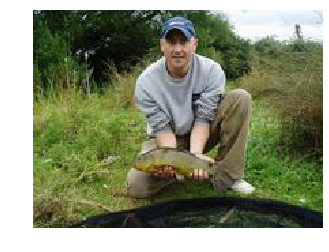

None


In [ ]:
let numpyImg = decodedImg.makeNumpyArray()
plt.imshow(numpyImg) 
plt.axis("off")
plt.show()

In [ ]:
//export
public func fetchFiles(path: Path, recurse: Bool = false, extensions: [String]? = nil) -> [Path]{
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += fetchFiles(path: p.path, recurse: recurse, extensions: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased) {
            res.append(p.path)
        }
    }
    return res
}

In [ ]:
time() { let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"]) }

1212.802035 ms


In [ ]:
let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"])

In [ ]:
fNames.count == 13394

true


## Prepare the data

`Dataset` can handle all the transforms that go on a `Tensor`, including opening an image and resizing it since it takes `StringTensor`. That makes the `tfms` attribute of `ItemList` irrelevant, so `ItemList` is just an array of `Item` with a path (if get method seems useful later, we can add it).

In [ ]:
// export
public struct ItemList<Item>{
    public var items: [Item]
    public let path: Path
    
    public init(items: [Item], path: Path){
        (self.items,self.path) = (items,path)
    }
}

In [ ]:
// export
public extension ItemList where Item == Path{
    init(fromFolder path: Path, extensions: [String], recurse: Bool = true) {
        self.init(items: fetchFiles(path: path, recurse: recurse, extensions: extensions),
                  path:  path)
    }
}

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])

### Split

In [ ]:
// export
public struct SplitData<Item>{
    public let train: ItemList<Item>
    public let valid: ItemList<Item>
    public var path: Path { return train.path }
    
    public init(train: ItemList<Item>, valid: ItemList<Item>){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(_ il: ItemList<Item>, fromFunc: (Item) -> Bool){
        var (trn, val): ([Item], [Item]) = ([], [])
        for x in il.items {
            if fromFunc(x) { val.append(x) }
            else           { trn.append(x) }
        }
        self.init(train: ItemList(items: trn, path: il.path),
                  valid: ItemList(items: val, path: il.path))
    }
}

In [ ]:
// export
public func grandParentSplitter(fName: Path, valid: String = "valid") -> Bool{
    return fName.parent.parent.basename() == valid
}

In [ ]:
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})

### Processor

In [ ]:
// export
public protocol Processor {
    associatedtype Input
    associatedtype Output
    
    mutating func initState(items: [Input])
    func process1(item: Input) -> Output
    func deprocess1(item: Output) -> Input
}

In [ ]:
// export
public extension Processor {
    
    func process(items: [Input]) -> [Output]{
        return items.map(){process1(item: $0)}
    }
    
    func deprocess(items: [Output]) -> [Input]{
        return items.map(){deprocess1(item: $0)}
    }
}

In [ ]:
// export
public struct NoopProcessor<Item>: Processor {
    public init() {}
    public typealias Input = Item
    public typealias Output = Item
    
    public mutating func initState(items: [Input]){}
    
    public func process1  (item: Input)  -> Output { return item }
    public func deprocess1(item: Output) -> Input  { return item }
}

In [ ]:
// export
public struct CategoryProcessor: Processor {
    public init() {}
    public typealias Input = String
    public typealias Output = Int32
    public var vocab: [Input]? = nil
    public var reverseMap: [Input: Output]? = nil
    
    public mutating func initState(items: [Input]){
        vocab = Array(Set(items)).sorted()
        reverseMap = [:]
        for (i,x) in vocab!.enumerated(){ reverseMap![x] = Int32(i) }
    }
    
    public func process1  (item: Input)  -> Output { return reverseMap![item]! }
    public func deprocess1(item: Output) -> Input  { return vocab![Int(item)] }
}

### Label

When we build the datasets, we don't need to return a tupe (item, label) but to have the tensor(s) with the items and the tensor(s) with the labels separately.

In [ ]:
//export
public struct LabeledItemList<PI,PL> where PI: Processor, PL: Processor{
    public var items: [PI.Output]
    public var labels: [PL.Output]
    public let path: Path
    public var procItem: PI
    public var procLabel: PL
    
    public init(rawItems: [PI.Input], rawLabels: [PL.Input], path: Path, procItem: PI, procLabel: PL){
        (self.procItem,self.procLabel,self.path) = (procItem,procLabel,path)
        self.items = procItem.process(items: rawItems)
        self.labels = procLabel.process(items: rawLabels)
    }
    
    public init(_ il: ItemList<PI.Input>, fromFunc: (PI.Input) -> PL.Input, procItem: PI, procLabel: PL){
        self.init(rawItems:  il.items,
                  rawLabels: il.items.map{ fromFunc($0)},
                  path:      il.path,
                  procItem:  procItem,
                  procLabel: procLabel)
    }
    
    public func rawItem (_ idx: Int) -> PI.Input { return procItem.deprocess1 (item: items[idx])  }
    public func rawLabel(_ idx: Int) -> PL.Input { return procLabel.deprocess1(item: labels[idx]) }
}

In [ ]:
//export
public struct SplitLabeledData<PI,PL> where PI: Processor, PL: Processor{
    public let train: LabeledItemList<PI,PL>
    public let valid: LabeledItemList<PI,PL>
    public var path: Path { return train.path }
    
    public init(train: LabeledItemList<PI,PL>, valid: LabeledItemList<PI,PL>){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(_ sd: SplitData<PI.Input>, fromFunc: (PI.Input) -> PL.Input, procItem: inout PI, procLabel: inout PL){
        procItem.initState (items: sd.train.items)
        let trainLabels = sd.train.items.map{ fromFunc($0) }
        procLabel.initState(items: trainLabels)
        self.init(train: LabeledItemList(rawItems: sd.train.items, rawLabels: trainLabels, path: sd.path, 
                                         procItem: procItem, procLabel: procLabel),
                  valid: LabeledItemList(sd.valid, fromFunc: fromFunc, procItem: procItem, procLabel: procLabel))
    }
}

In [ ]:
//export
public func parentLabeler(_ fName: Path) -> String { return fName.parent.basename() }

In [ ]:
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)

In [ ]:
print(sld.train.labels[0])
print(sld.train.rawLabel(0))
print(sld.train.procLabel.vocab!)

9
n03888257
["n01440764", "n02102040", "n02979186", "n03000684", "n03028079", "n03394916", "n03417042", "n03425413", "n03445777", "n03888257"]


### Datasets

To go in a Dataset, our array of items and array of labels need to be converted to tensors.

In [ ]:
// export
public struct LabeledElement<I: TensorGroup, L: TensorGroup>: TensorGroup {
    public var xb: I
    public var yb: L    
    
    public init(xb: I, yb: L){
        (self.xb, self.yb) = (xb, yb)
    }
}

In [ ]:
// export
public extension SplitLabeledData {
    func toDataBunch<XB, YB> (
        itemToTensor: ([PI.Output]) -> XB, labelToTensor: ([PL.Output]) -> YB, batchSize: Int = 64
    ) -> DataBunch<LabeledElement<XB, YB>> where XB: TensorGroup, YB: TensorGroup {
        let trainDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(train.items), yb: labelToTensor(train.labels)))
        let validDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(valid.items), yb: labelToTensor(valid.labels)))
        return DataBunch(train: trainDs, valid: validDs, batchSize: batchSize)
    }
}

In [ ]:
// export
public func pathsToTensor(_ paths: [Path]) -> StringTensor { return StringTensor(paths.map{ $0.string })}
public func intsToTensor(_ items: [Int32]) -> Tensor<Int32> { return Tensor<Int32>(items)}

In [ ]:
let dataset = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)

### Transforms

We directly plug in to the dataset the transforms we want to apply.

In [ ]:
// export
public func transformData<I,TI,L>(
    _ data: DataBunch<LabeledElement<I,L>>, 
    tfmItem: (I) -> TI
) -> DataBunch<DataBatch<TI,L>> 
where I: TensorGroup, TI: TensorGroup & Differentiable, L: TensorGroup{
    return DataBunch(train: data._train.map{ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     valid: data._valid.map{ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     batchSize: data.batchSize)
}

In [ ]:
// export
public func openAndResize(fname: StringTensor, size: Int) -> TF{
    let imgBytes = Raw.readFile(filename: fname)
    let decodedImg = Raw.decodeJpeg(contents: imgBytes, channels: 3, dctMethod: "")
    let resizedImg = Tensor<Float>(Raw.resizeNearestNeighbor(
        images: Tensor<UInt8>([decodedImg]), 
        size: Tensor<Int32>([Int32(size), Int32(size)])))
    return resizedImg.reshaped(to: TensorShape(size, size, 3))
}

In [ ]:
let tfmData = transformData(dataset, tfmItem: { openAndResize(fname: $0, size: 128) })

In [ ]:
var firstBatch: DataBatch<TF, TI>? = nil
for batch in tfmData.train {
    firstBatch = batch
    break
}

In [ ]:
firstBatch!.xb.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 64
    - 1 : 128
    - 2 : 128
    - 3 : 3


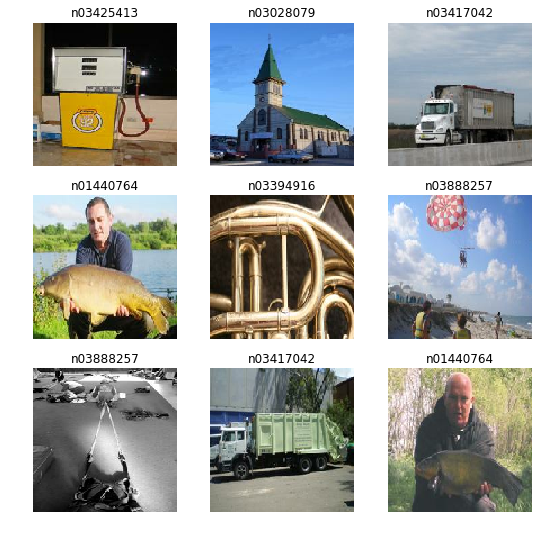

None


In [ ]:
let (rows,cols) = (3,3)
plt.figure(figsize: [9, 9])
for i in 0..<(rows * cols) {
    let img = plt.subplot(rows, cols, i + 1)
    img.axis("off")
    let x = firstBatch!.xb[i].makeNumpyArray()
    img.imshow(x.astype(np.uint8))
    let title = sld.train.procLabel.vocab![Int(firstBatch!.yb[i].scalarized())]
    img.set_title(title)
    if (i + 1) >= (rows * cols) { break }
}
plt.show()

### To conclude:

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)
var data = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let tfmData = transformData(data, tfmItem: { openAndResize(fname: $0, size: 128) })

## Export

In [ ]:
notebookToScript(fname: (Path.cwd / "08_data_block.ipynb").string)